In [ ]:
import cv2
from PIL import Image
import numpy as np
import h5py
import os
import cv2
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
import matplotlib.pyplot as plt

# Подготовка датасета

Так как датасет содержит в себе много объектов и сохранение всех изображений в формате jpg и ему подобным будет занимать слишком много места, то одним из возможных вариантов сохраения данных и быстрого доступа к ним является использование формата h5.

Также целесообразно разместить датасет на гугл диске, таким образом чтобы получить к нему доступ, то удобно использовать следующую команду

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Архитектура нейронной сети

В данной работе мы решаем задачи сегментации и детекции: на полученном изображении необходимо выделить дороги. Для этой задачи подходит архитектура U-Net. 

Оценка качества детекции будем производить при помощи известной метрики - Intersection over Union.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

Реализация архитектуры U-Net при помощи фреймворка Keras. Архитектура более подробно рассмотрена в отчете

In [ ]:
def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])

    
    return model

Так как мы работаем с изображениями, то удобно нормировать координаты поиска дороги на кол-во пикселей - 255 и использовать маски - контуры объекта на уровне пикселей.

In [ ]:
print('-'*40)
print('Загружаем и предобрабатываем изображения...')
print('-'*40)
file = h5py.File('Dataset_train.h5', 'r')
img_train = file.get('images')
mask_train = file.get('masks')
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_train = img_train.astype('float32')
img_train /= 255

mask_train = mask_train.astype('float32')
mask_train /= 255  # scale masks to [0, 1]

print('-' * 40)
print('Создаем и запускаем модель...')
print('-' * 40)
model = unet()

----------------------------------------
Загружаем и предобрабатываем изображения...
----------------------------------------
----------------------------------------
Создаем и запускаем модель...
----------------------------------------


Выведем архитектуру модели

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Проводим обучение нейронной сети при помощи фреймворка TensorFlow. Запуск занимает продолжительное время, предпочтительнее использовать cuda в сочетании с GPU.

In [ ]:
print('-' * 40)
print('Обучение модели...')
print('-' * 40)

epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'weights_bceloss_{epochs}epochs.h5', monitor='val_loss', save_best_only=True)

history =  model.fit(img_train, mask_train, batch_size=16, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, early_stopping])

----------------------------------------
Обучение модели...
----------------------------------------
Epoch 1/100
105/105 [==============================] - 169s 1s/step - loss: 0.6768 - dice_coef: 0.1852 - iou_coef: 0.1005 - val_loss: 0.6532 - val_dice_coef: 0.1681 - val_iou_coef: 0.0896
Epoch 2/100
105/105 [==============================] - 125s 1s/step - loss: 0.6372 - dice_coef: 0.1834 - iou_coef: 0.0992 - val_loss: 0.6171 - val_dice_coef: 0.1665 - val_iou_coef: 0.0884
Epoch 3/100
105/105 [==============================] - 125s 1s/step - loss: 0.6042 - dice_coef: 0.1812 - iou_coef: 0.0978 - val_loss: 0.5846 - val_dice_coef: 0.1647 - val_iou_coef: 0.0872
Epoch 4/100
105/105 [==============================] - 125s 1s/step - loss: 0.5747 - dice_coef: 0.1791 - iou_coef: 0.0964 - val_loss: 0.5554 - val_dice_coef: 0.1629 - val_iou_coef: 0.0860
Epoch 5/100
105/105 [==============================] - 125s 1s/step - loss: 0.5483 - dice_coef: 0.1769 - iou_coef: 0.0950 - val_loss: 0.5292 - val_

Выполним предсказание на тестовом датасете

In [ ]:
file = h5py.File('Dataset_test.h5', 'r')
img_test = file.get('images')
mask_test = file.get('masks')
img_test = np.array(img_test)
mask_test = np.array(mask_test)
img_test = img_test.astype('float32')

img_test /= 255

print('-' * 40)
print('Загружаем веса модели...')
print('-' * 40)
#model.load_weights('weights.h5')

print('-' * 40)
print('Предсказываем контуры на тестовых данных...')
print('-' * 40)
mask_pred = model.predict(img_test, verbose=1)

----------------------------------------
Загружаем веса модели...
----------------------------------------
----------------------------------------
Предсказываем контуры на тестовых данных...
----------------------------------------
1/1 [==============================] - 11s 11s/step


Сохраняем предсказания в отдельную директорию

In [ ]:
print('-' * 40)
print('Сохраняем предсказания...')
print('-' * 40)
pred_dir = 'Preds2'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_test):
    image = (image * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_pred.png'), image)

----------------------------------------
Сохраняем предсказания...
----------------------------------------


В результате обучения для того чтобы увидеть как менялось качество модели, выполним визуализацию для функции потерь. Чем функция потерь меньше, тем больше качество модели

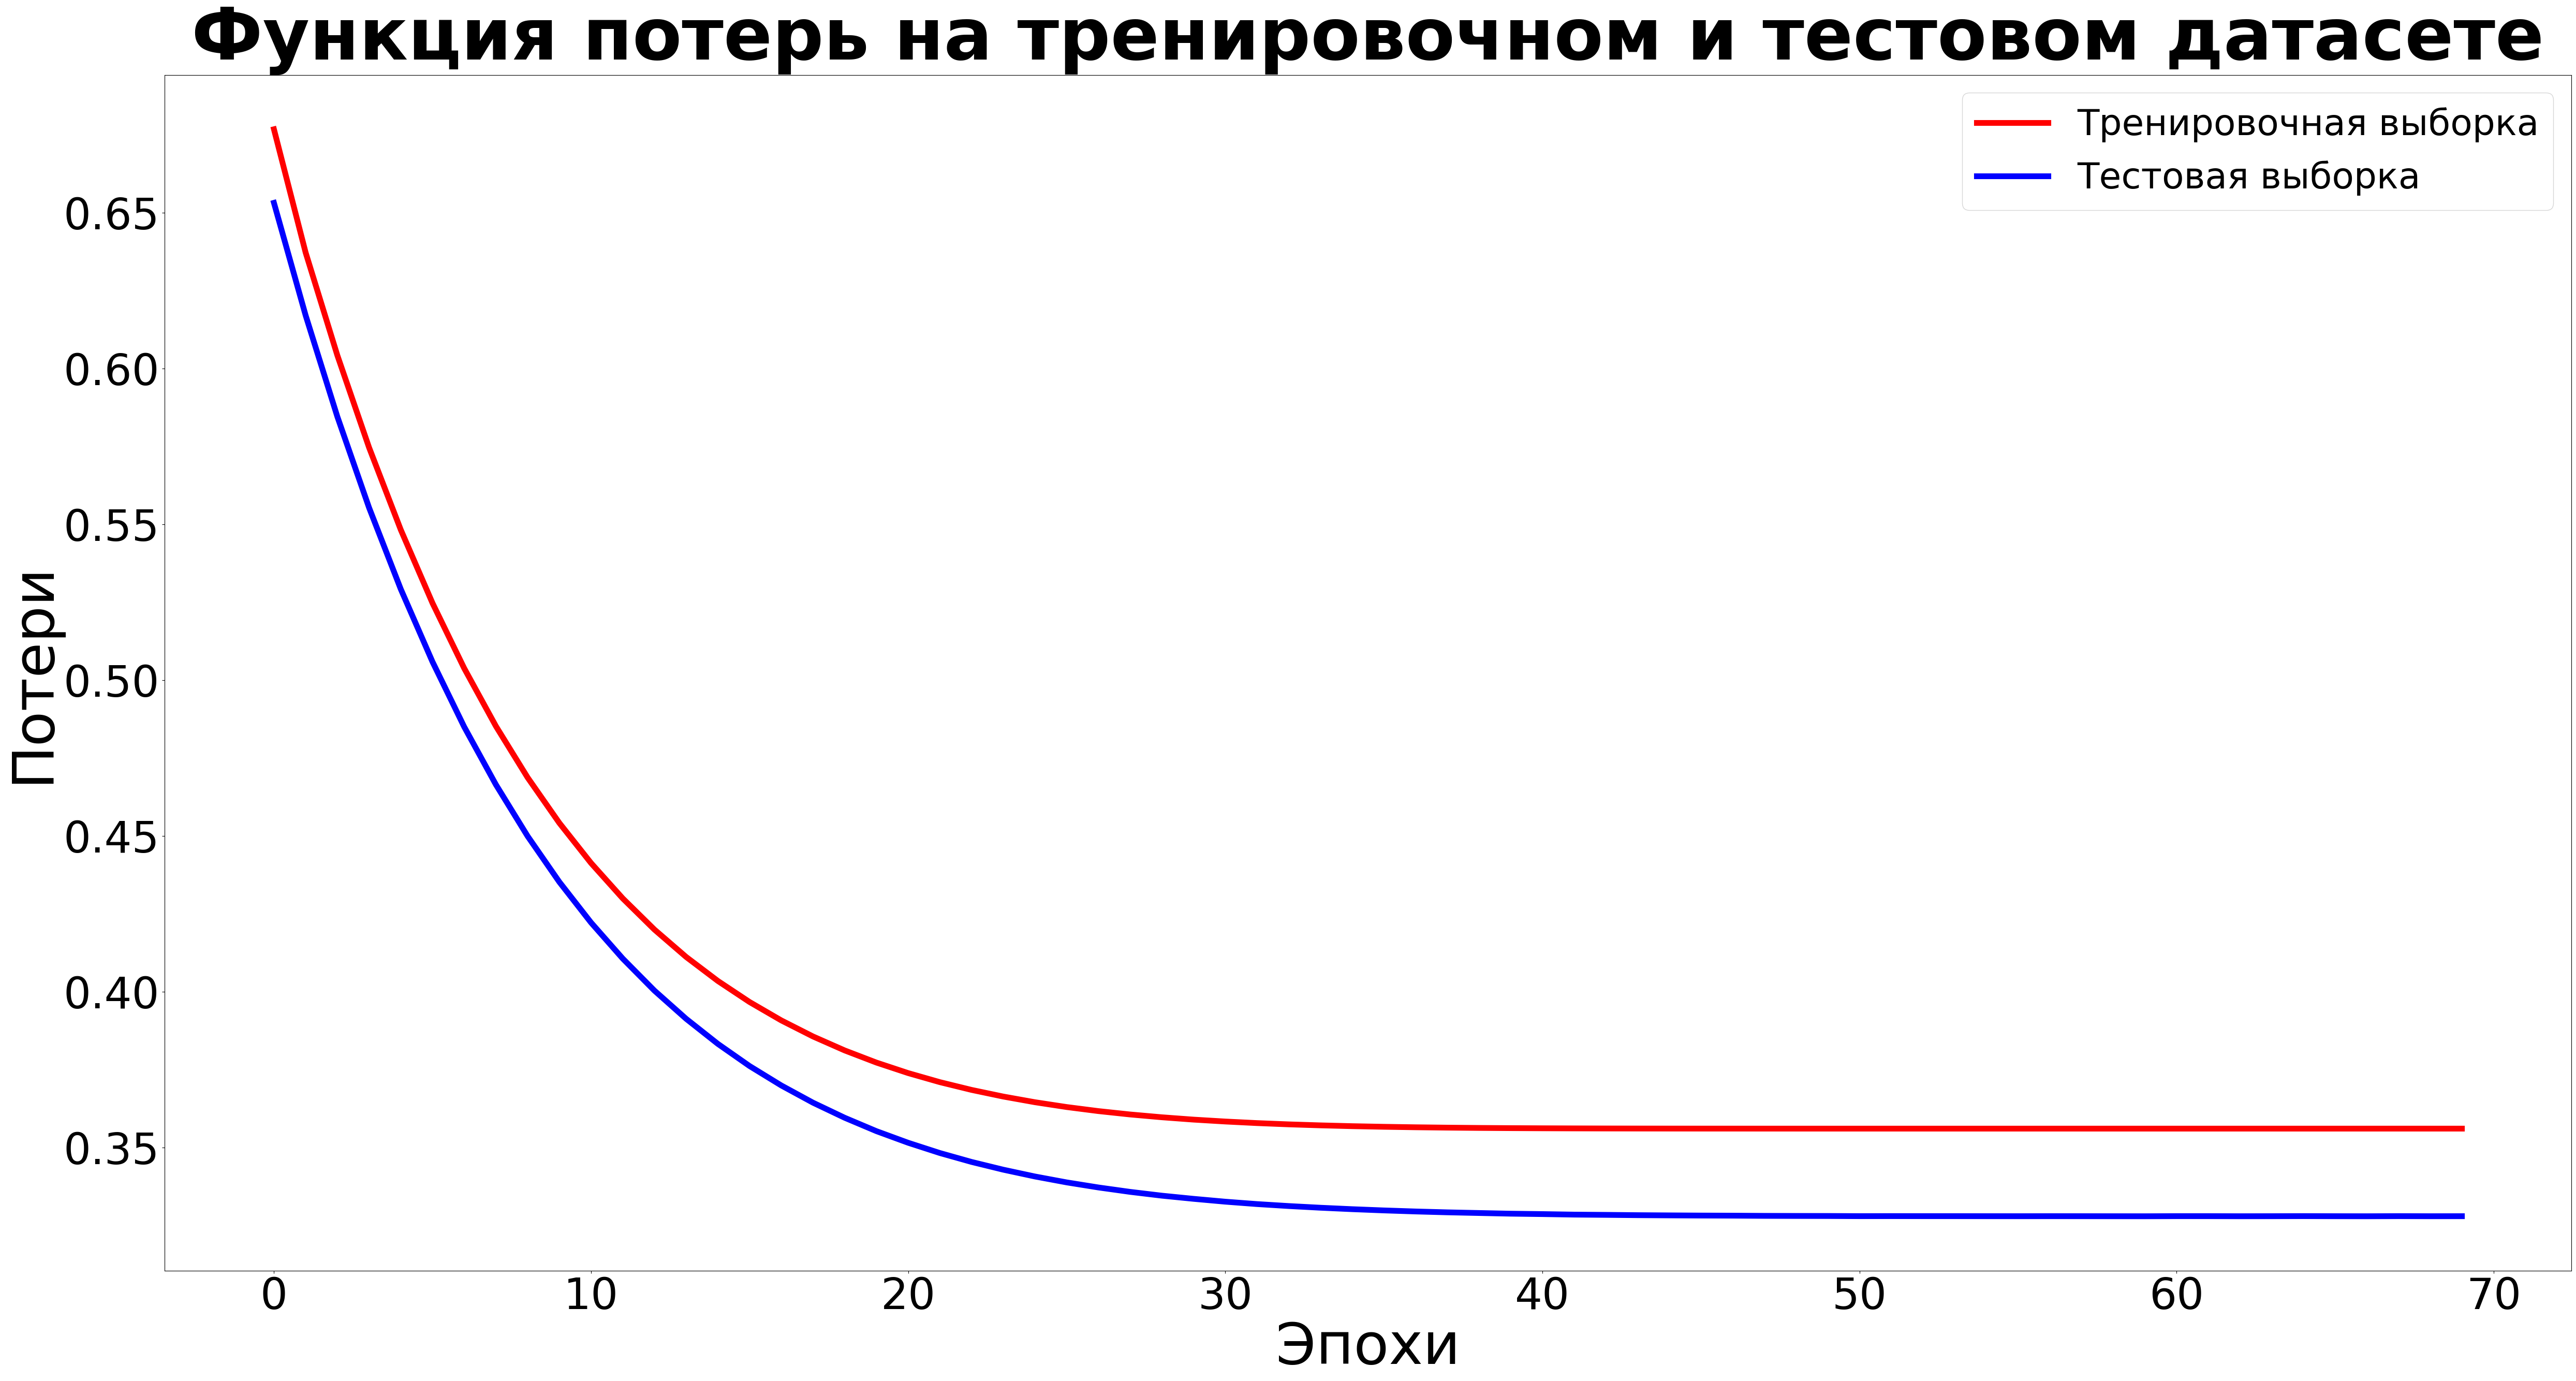

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(60, 30))
plt.plot(history.history['loss'], linewidth=8, color='r')                   
plt.plot(history.history['val_loss'], linewidth=8, color='b')
plt.title('Функция потерь на тренировочном и тестовом датасете', fontsize=100, fontweight="bold")
plt.ylabel('Потери', fontsize=80)
plt.xlabel('Эпохи', fontsize=80)
plt.legend(['Тренировочная выборка', 'Тестовая выборка'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()
plt.savefig("plot.jpg")